<center><h1>Custom Multi-Layer Perceptron (MLP)</h1></center>
<center><h3>Implementing an MLP from scratch</h3></center>
<br>

## Imports

In [1]:
from utils import print_confusion_matrix

from mnist_dataset import (
    load_raw_MNIST_dataset,
    plot_random_images_from_raw_MNIST_dataset,
    format_raw_MNIST_dataset
)

from layers import (
    InputLayer,
    DenseLayer,
    ActivationLayer,
    BatchNormLayer,
    DropoutLayer
)

from network import Network

print("Done")

Done


## Loading and formatting the data

The following seed is currently used to :
- Randomly split the raw data into the "train", "val" and "test" sets
- Randomly shuffle the "train", "val" and "test" sets

Set this seed to `None` for "real" randomness during those 2 processes

In [2]:
seed_data_formatting = 555

Defining the number of samples in the "train", "val" and "test" sets<br>
NB : The validation set is extracted from the raw "train" data, not from the raw "test" data. As a reminder, there are :
- 60000 samples in the raw "train" data
- 10000 samples in the raw "test" data

In [3]:
nb_train_samples = 10000
nb_val_samples   = 1000
nb_test_samples  = 1000

Loading the raw data :

In [4]:
raw_X_train, raw_y_train, raw_X_test, raw_y_test = load_raw_MNIST_dataset(
    verbose=False
)


The raw MNIST dataset was successfully loaded. Done in 0.267 seconds


Plotting random samples of each digit (from the raw data) :

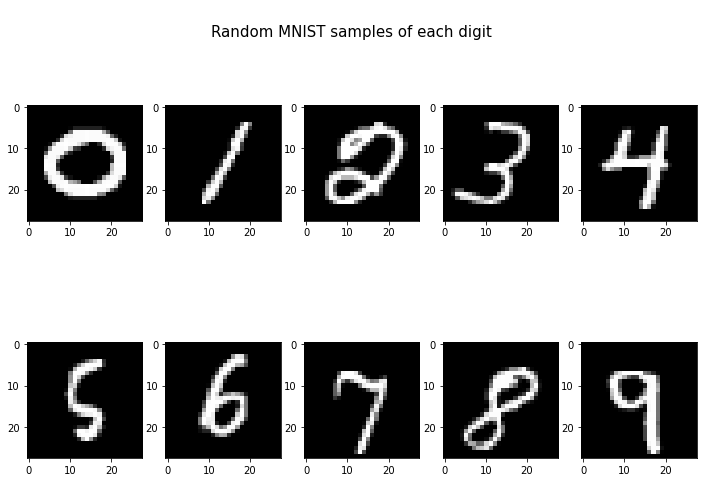

In [5]:
plot_random_images_from_raw_MNIST_dataset(
    raw_X_train,
    raw_y_train,
    raw_X_test,
    raw_y_test,
    seed=None
)

Formatting the raw data :

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = format_raw_MNIST_dataset(
    raw_X_train,
    raw_y_train,
    raw_X_test,
    raw_y_test,
    nb_train_samples,
    nb_val_samples,
    nb_test_samples,
    nb_shuffles=20,
    seed=seed_data_formatting,
    verbose=False
)


The raw MNIST dataset was successfully formatted. Done in 0.451 seconds


Defining the input and output sizes of the network (respectively) :

In [7]:
nb_pixels_per_image = X_train.shape[1] # = 28 * 28 = 784 pixels per image
nb_classes = y_train.shape[1] # = 10 digits

In [8]:
nb_pixels_per_image

784

In [9]:
nb_classes

10

## Defining the hyperparameters of the Multi-Layer Perceptron (MLP) network

The following seed is currently used to :<br>
- Randomly initialize the weights and biases of the Dense layers
- Randomly generate the dropout matrices of the Dropout layers (if these layers are used)
- Randomly split the training data into batches during the training phase (at each epoch)

Set this seed to `None` for "real" randomness during those 3 processes

In [10]:
seed_network = 1555

Main hyperparameters :

In [11]:
nb_epochs = 5
learning_rate = 0.15

train_batch_size = 40

nb_neurons_hidden_dense_layers = [
    256,
    64,
    32
]

use_batch_norm_layers = False

use_dropout_layers = False
if use_dropout_layers:
    # The Dropout layer randomly sets input units to 0 with a frequency of
    # `dropout_rate` at each step during the training phase. This regularization
    # method helps prevent overfitting
    dropout_rate = 0.10

## Building the MLP network architecture from the previously defined hyperparameters

### Initializing the network

If you set `normalize_input_data` to `True`, every time the data will be split into batches (during the training, validation AND testing phases), each resulting batch will be normalized such that its mean is 0 and its standard deviation is 1. It's HIGHLY recommended to set `normalize_input_data` to `True` here, in order to have better performances

In [12]:
network = Network(normalize_input_data=True)

Input layer :

In [13]:
network.add(InputLayer(input_size=nb_pixels_per_image))

### Hidden layers

In [14]:
for hidden_layer_index, nb_neurons in enumerate(nb_neurons_hidden_dense_layers):
    network.add(DenseLayer(nb_neurons, seed=seed_network+hidden_layer_index))
    
    """
    Possible relevant choices here (the activation name is case insensitive) :
        network.add(ActivationLayer("ReLU"))
        OR
        network.add(ActivationLayer("leaky_ReLU", leaky_ReLU_coeff=0.01))
        OR
        network.add(ActivationLayer("tanh"))
    """
    
    if use_batch_norm_layers:
        # Adding a BatchNorm regularization layer (if requested)
        network.add(BatchNormLayer())
    
    # Adding an activation layer (usually ReLU)
    network.add(ActivationLayer("ReLU"))
    
    if use_dropout_layers:
        # Adding a dropout regularization layer (if requested)
        network.add(DropoutLayer(dropout_rate, seed=seed_network+hidden_layer_index))

### Output layer

In [15]:
network.add(DenseLayer(nb_classes, seed=seed_network+len(nb_neurons_hidden_dense_layers)))

"""
Possible relevant choices here (the activation name is case insensitive) :
    network.add(ActivationLayer("softmax"))
    OR
    network.add(ActivationLayer("sigmoid"))
"""

# Adding the very last activation layer (usually softmax)
network.add(ActivationLayer("softmax"))

### Displaying the summary of the network's architecture

In [16]:
# NB : The kwargs of this method will only affect how the summary will look
#      like when it's printed (they won't affect the summary's contents)
network.summary(
    initial_spacing=1,
    column_separator="|", # can be multiple characters long
    row_separator="-",    # has to be a single character
    bounding_box="*"      # has to be a single character
)

# Or, equivalently, you can run : `print(network)`


 *****************************************************************************************
 *                                                                                       *
 *                                    NETWORK SUMMARY                                    *
 *                                                                                       *
 *    Layer                  |  Input shape  |  Output shape  |  Trainable parameters    *
 *    -----------------------|---------------|----------------|----------------------    *
 *    Input(784)             |  (None, 784)  |  (None, 784)   |  0                       *
 *    Dense(256)             |  (None, 784)  |  (None, 256)   |  200,960                 *
 *    Activation("relu")     |  (None, 256)  |  (None, 256)   |  0                       *
 *    Dense(64)              |  (None, 256)  |  (None, 64)    |  16,448                  *
 *    Activation("relu")     |  (None, 64)   |  (None, 64)    |  0                       

## Setting the loss function of the network

In [17]:
"""
Possible relevant choices here (the loss function name is case insensitive) :
    network.set_loss_function("MSE") # MSE = Mean Square Error
    OR
    network.set_loss_function("CCE") # CCE = Categorical Cross-Entropy
"""

network.set_loss_function("MSE")

## Training phase

In [18]:
training_data = (X_train, y_train)
validation_data = (X_val, y_val)

In [19]:
network.fit(
    training_data,
    validation_data,
    nb_epochs,
    learning_rate,
    train_batch_size,
    nb_shuffles_before_train_batch_split=10,
    seed_train_batch_split=seed_network,
    val_batch_size=32
)


# ----------------------------------------------------------------------------------------------- #

     Starting the training loop ...

     epoch 1/5  -  loss=0.0515  -  val_loss=0.0241  -  accuracy=0.6151  -  val_accuracy=0.8540                                                        
     epoch 2/5  -  loss=0.0193  -  val_loss=0.0168  -  accuracy=0.8756  -  val_accuracy=0.8940                                                        
     epoch 3/5  -  loss=0.0137  -  val_loss=0.0141  -  accuracy=0.9146  -  val_accuracy=0.9090                                                        
     epoch 4/5  -  loss=0.0112  -  val_loss=0.0128  -  accuracy=0.9302  -  val_accuracy=0.9150                                                        
     epoch 5/5  -  loss=0.0096  -  val_loss=0.0119  -  accuracy=0.9402  -  val_accuracy=0.9220                                                        

     Training complete ! Done in 20.3 seconds (4.1 s/epoch, 0.016 s/batch)

# ---------------------------

## RESULTS

Plotting the network's history :

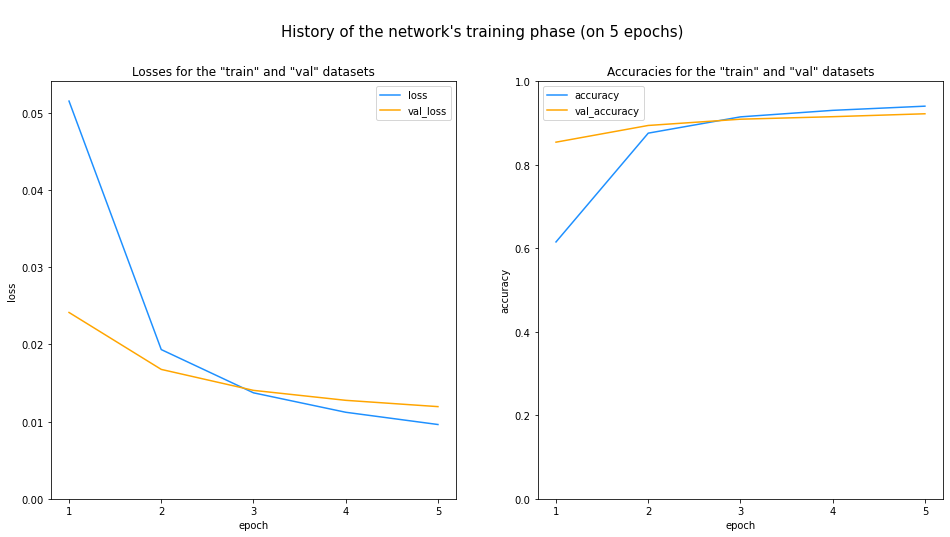

In [20]:
network.plot_history(
    save_plot_to_disk=False,
    saved_image_name="network_history" # it will be saved as a PNG image by default
)

Computing the accuracy score and the confusion matrix :

In [21]:
acc_score, conf_matrix = network.evaluate(
    X_test,
    y_test,
    test_batch_size=32
)

Displaying the confusion matrix :

In [22]:
# NB : When you load this notebook for the first time, the diagonal won't be
#      highlighted in green (the output will be the unstyled confusion matrix).
#      Simply re-run the entire notebook to see the highlighting of the diagonal !
print_confusion_matrix(
    conf_matrix,
    normalize="rows", # = "rows", "columns" or "no"
    precision=1,
    jupyter_notebook=True
)


CONFUSION MATRIX (normalized="rows") :


ACTUAL,0,1,2,3,4,5,6,7,8,9
PREDICTED,,,,,,,,,,
0,93.2 %,0.0 %,2.9 %,0.0 %,0.0 %,1.9 %,0.0 %,0.0 %,1.9 %,0.0 %
1,0.0 %,97.4 %,0.9 %,0.0 %,0.0 %,0.9 %,0.0 %,0.0 %,0.0 %,0.9 %
2,1.0 %,0.0 %,94.0 %,1.0 %,1.0 %,0.0 %,0.0 %,1.0 %,1.0 %,1.0 %
3,0.0 %,0.0 %,0.0 %,92.9 %,0.0 %,4.0 %,0.0 %,1.0 %,1.0 %,1.0 %
4,0.0 %,0.0 %,0.0 %,0.0 %,93.8 %,1.0 %,1.0 %,0.0 %,2.1 %,2.1 %
5,0.0 %,0.0 %,1.2 %,2.5 %,0.0 %,92.6 %,0.0 %,0.0 %,1.2 %,2.5 %
6,0.0 %,1.0 %,0.0 %,0.0 %,2.0 %,0.0 %,95.9 %,0.0 %,0.0 %,1.0 %
7,0.0 %,0.0 %,0.9 %,2.8 %,0.0 %,0.9 %,0.9 %,92.5 %,0.9 %,0.9 %
8,1.0 %,0.0 %,2.1 %,1.0 %,0.0 %,4.1 %,0.0 %,0.0 %,90.7 %,1.0 %


Displaying the global accuracy score :

In [23]:
precision = 2 # by default
print(f"\nGLOBAL ACCURACY : {acc_score:.{precision}f} %\n")


GLOBAL ACCURACY : 93.20 %



Displaying some of the network's predictions (for testing purposes only) :

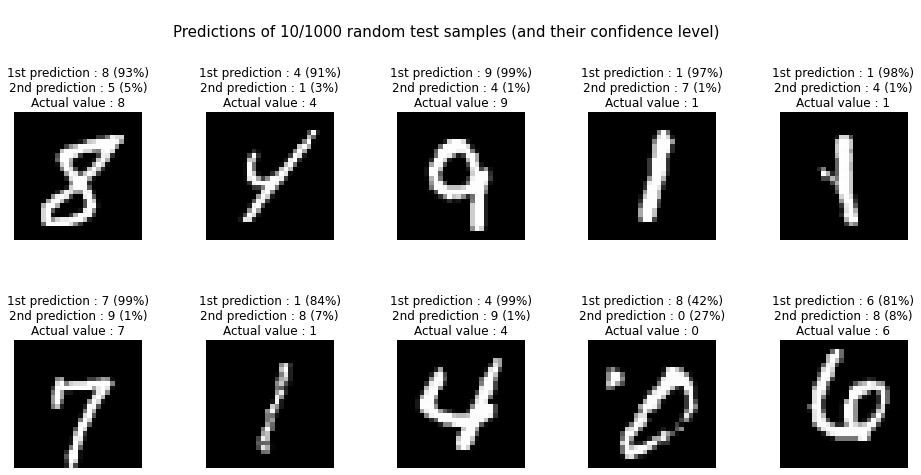

In [24]:
network.display_some_predictions(
    X_test,
    y_test,
    seed=None
)

<center><h2>END</h2></center>